<a href="https://colab.research.google.com/github/AmritaNambiar/INFO202_ABSA_Hotel_Reviews/blob/main/absa_hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Imports
import re
import unicodedata
import pandas as pd
import torch
import nltk
import os

# Download necessary NLTK data for tokenization
nltk.download('punkt')
nltk.download('punkt_tab')

from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize


from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Define the path to the dataset
dataset_path = '[INFO 202]Annotated_Hotel_Reviews.csv'

# Load the dataset into a Pandas DataFrame
df_hotel_reviews = pd.read_csv(dataset_path)

# Calculate the number of tokens in the 'review_text' column
df_hotel_reviews['review_token_count'] = df_hotel_reviews['review_text'].apply(lambda x: len(word_tokenize(str(x))))

# Arrange the rows by the number of tokens in descending order
df_hotel_reviews = df_hotel_reviews.sort_values(by='review_token_count', ascending=False).reset_index(drop=True)

# Display the first 5 rows of the DataFrame with the new token count and sorted order
print("\nFirst 5 rows of the DataFrame after sorting by review_token_count (descending):")
print(df_hotel_reviews.head())

In [ ]:
# Randomly selecting 100 reviews
dataset_directory = os.path.dirname(dataset_path)

# Define the new file path for the randomly selected 100 rows
output_file_path = os.path.join(dataset_directory, 'Hotel_Reviews_Sample_100_Rows.csv')

# Randomly select 100 rows from the DataFrame
df_sample = df_hotel_reviews.sample(n=100, random_state=42)

# Save the sample DataFrame to a new CSV file
df_sample.to_csv(output_file_path, index=False)

print(f"Successfully saved 100 randomly selected rows to: {output_file_path}")

# Display the head of the sample DataFrame to confirm
print("\nFirst 5 rows of the sample DataFrame:")
print(df_sample.head())

In [5]:

# Load annotated hotel reviews
# The CSV contains one row per review, with one column per aspect
# (Location, Room, Cleanliness, etc.) annotated as -1/0/1 for sentiment.[file:2]
# Define the path to the dataset
dataset_path = '/content/drive/MyDrive/[INFO 202]Annotated_Hotel_Reviews.csv'

# Load the dataset into a Pandas DataFrame
df_hotel_reviews = pd.read_csv(dataset_path)

print(df_hotel_reviews.head())


   index  rating                                        review_text  Location  \
0  14670     4.6  Fist impression was very bad and it was my tri...         1   
1  19695     5.4  We had to order and pay for our breakfasts for...         1   
2  21741     7.0  The pillows were a bit strange and uncomfortab...         1   
3   7804    10.0  The main things to consider before booking thi...         0   
4   2544     7.0  Despite initially looking at this hotel for me...         1   

   Room  Cleanliness  Service  Facilities  Food_and_beverage  Price  Safety  
0    -1            0       -1          -1                  0     -1       0  
1    -1           -1       -1          -1                 -1     -1      -1  
2    -1            0       -1          -1                  0      1       0  
3     1            1        1           1                  1      0       1  
4     0            0       -1          -1                 -1     -1       0  


In [6]:
# Fixed aspects provided in the prompt
aspect_cols = [
    "Location",
    "Room",
    "Cleanliness",
    "Service",
    "Facilities",
    "Food_and_beverage",
    "Price",
    "Safety",
]

# Map numeric labels in the CSV to class IDs for the model:
#   -1 -> 0 (negative), 0 -> 1 (neutral), 1 -> 2 (positive)
label_map = {-1: 0, 0: 1, 1: 2}

In [8]:
# Text preprocessing function

def clean_text(text: str) -> str:
    """
    Light, BERT-friendly preprocessing:
    - Normalize unicode (NFKC)
    - Lowercase (for uncased BERT)
    - Remove control characters
    - Normalize whitespace
    - Slightly normalize repeated punctuation
    """
    if not isinstance(text, str):
        text = str(text)

    # Normalize Unicode (e.g., fancy quotes, accents) to a consistent form
    text = unicodedata.normalize("NFKC", text)

    # Lowercasing is standard for bert-base-uncased
    text = text.lower()

    # Remove control characters while keeping newlines if you want them
    text = "".join(
        ch
        for ch in text
        if ch == "\n" or unicodedata.category(ch)[0] != "C"
    )

    # Collapse multiple whitespace characters into a single space
    text = re.sub(r"\s+", " ", text).strip()

    # Reduce long runs of "!!!" or "???", but keep punctuation
    text = re.sub(r"([!?]){3,}", r"\1\1", text)

    return text

# Apply preprocessing to the review_text column from the annotated CSV.
df_hotel_reviews["review_text_clean"] = df_hotel_reviews["review_text"].apply(clean_text)

In [11]:
# Convert table to (review, aspect) pairs

# Input to BERT: (review_text_clean, aspect_name)
# Output label: sentiment for that aspect (negative/neutral/positive).
records = []

for _, row in df_hotel_reviews.iterrows():
    review = row["review_text_clean"]
    rating = float(row["rating"])

    for aspect in aspect_cols:
        raw_label = row[aspect]

        # Skip if label is missing
        if pd.isna(raw_label):
            continue

        raw_label = int(raw_label)

        # Skip unusual labels if any
        if raw_label not in label_map:
            continue

        records.append(
            {
                "review": review,
                # Use a nicer surface form for the aspect
                "aspect": aspect.replace("_", " & "),
                # Map to -1/0/1 for model training
                "sent_class": label_map[raw_label],
                "rating": rating,
            }
        )

# Create a DataFrame with one row per (review, aspect) pair
data = pd.DataFrame(records)

In [12]:
# Train / validation split
# Stratify by sentiment to keep label distribution similar in both splits.
train_df, val_df = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data["sent_class"],
)

In [13]:
# Tokenizer (BERT) and Dataset

# BERT tokenizer will:
# - tokenize into subwords
# - add [CLS], [SEP] tokens
# - create token type ids for sentence pair tasks.[file:1]
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


class AspectSentimentDataset(Dataset):
    """
    PyTorch Dataset for aspect-based sentiment:
    each item = (input_ids, attention_mask, token_type_ids, label)
    where inputs correspond to:
        text = review text
        text_pair = aspect phrase
    """

    def __init__(self, df, tokenizer, max_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["review"]
        aspect = row["aspect"]
        label = int(row["sent_class"])

        # Sentence-pair encoding: (review, aspect)
        enc = self.tokenizer(
            text,
            aspect,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        # Remove batch dimension for DataLoader
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item


# Instantiate datasets
train_ds = AspectSentimentDataset(train_df, tokenizer)
val_ds = AspectSentimentDataset(val_df, tokenizer)

# DataLoaders for mini-batch training
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# Model, optimizer, scheduler setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute Class Weights (To handle imbalance)
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=train_df['sent_class']
)
class_weights = torch.tensor(class_weights_arr, dtype=torch.float).to(device)

print("Computed Class Weights:")
for i, label in enumerate(['negative', 'neutral', 'positive']):
    print(f"  {label}: {class_weights[i]:.4f}")

# BERT with a classification head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Number of epochs and training steps for scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

# Linear warmup + decay learning rate schedule
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

Computed Class Weights:
  negative: 1.2331
  neutral: 0.9969
  positive: 0.8432


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Training and validation loop

import torch.nn as nn

def run_epoch(dataloader, training=True):
    """
    Run one epoch of training or validation.

    Returns:
    - average loss
    - all predictions
    - all true labels
    """
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    all_preds, all_labels = [], []

    # Use weighted CrossEntropyLoss
    loss_fct = nn.CrossEntropyLoss(weight=class_weights)

    for batch in dataloader:
        # Move all batch tensors to device (CPU/GPU)
        batch = {k: v.to(device) for k, v in batch.items()}

        # Enable gradient computation only during training
        with torch.set_grad_enabled(training):
            outputs = model(**batch)
            logits = outputs.logits
            # Calculate loss with weights
            loss = loss_fct(logits.view(-1, 3), batch["labels"].view(-1))

        if training:
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Accumulate loss (weighted by batch size)
        total_loss += loss.item() * batch["input_ids"].size(0)

        # Move predictions and labels back to CPU for metrics
        preds = torch.argmax(logits, dim=-1).detach().cpu()
        labels = batch["labels"].detach().cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss, all_preds, all_labels


# Train for a few epochs
print("Starting training with class weights...")
for epoch in range(num_epochs):
    train_loss, _, _ = run_epoch(train_loader, training=True)
    val_loss, val_preds, val_labels = run_epoch(val_loader, training=False)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train loss: {train_loss:.4f}")
    print(f"  Val loss:   {val_loss:.4f}")

Starting training with class weights...
Epoch 1/3
  Train loss: 1.0509
  Val loss:   0.8903
Epoch 2/3
  Train loss: 0.8091
  Val loss:   0.8543
Epoch 3/3
  Train loss: 0.7086
  Val loss:   0.7495


In [16]:
# Evaluation: classification metrics

# Map class IDs sentiment labels
target_names = ["negative", "neutral", "positive"]

print(
    classification_report(
        val_labels,
        val_preds,
        target_names=target_names,
        digits=3,
    )
)


              precision    recall  f1-score   support

    negative      0.702     0.750     0.725        44
     neutral      0.590     0.434     0.500        53
    positive      0.689     0.810     0.745        63

    accuracy                          0.669       160
   macro avg      0.660     0.664     0.657       160
weighted avg      0.660     0.669     0.658       160



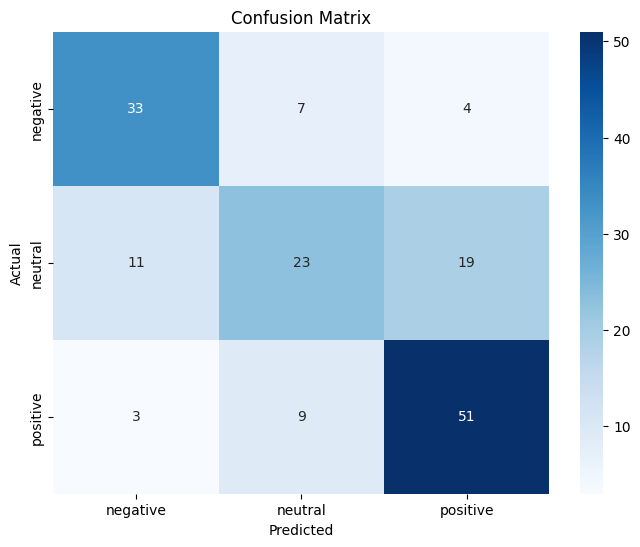

In [17]:
# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print("Class distribution in training data:")
class_counts = train_df['sent_class'].value_counts(normalize=True) * 100
# Map back to human-readable labels for clarity
class_counts = class_counts.rename(index={0: 'negative', 1: 'neutral', 2: 'positive'})
print(class_counts)


Class distribution in training data:
sent_class
positive    39.53125
neutral     33.43750
negative    27.03125
Name: proportion, dtype: float64


In [19]:
print("Class distribution in validation data:")
class_counts_val = val_df['sent_class'].value_counts(normalize=True) * 100
# Map back to human-readable labels for clarity
class_counts_val = class_counts_val.rename(index={0: 'negative', 1: 'neutral', 2: 'positive'})
print(class_counts_val)


Class distribution in validation data:
sent_class
positive    39.375
neutral     33.125
negative    27.500
Name: proportion, dtype: float64


In [20]:
# Inference helper for decision support

# Simple mapping from ID -> label
id2label = {0: "negative", 1: "neutral", 2: "positive"}


def analyze_review(review_text: str):
    # Run aspect-based sentiment analysis on a single review.

    clean = clean_text(review_text)
    model.eval()
    results = {}

    for aspect in aspect_cols:
        aspect_name = aspect.replace("_", " & ")

        # Encode (review, aspect) as a BERT sentence pair
        enc = tokenizer(
            clean,
            aspect_name,
            padding="max_length",
            truncation=True,
            max_length=256,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        # Predict sentiment
        with torch.no_grad():
            logits = model(**enc).logits
        pred_id = int(torch.argmax(logits, dim=-1).cpu().item())

        results[aspect_name] = id2label[pred_id]

    return results



In [21]:
import shutil
import os

# Check if model and tokenizer exist in memory
if 'model' not in globals() or 'tokenizer' not in globals():
    print("\u26a0\ufe0f Error: Model or Tokenizer not found!")
    print("Please re-run the 'Model Setup' and 'Training' cells to define and train the model before saving.")
else:
    # Save the model and tokenizer to a local directory
    output_dir = "hotel_absa_model"
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Model and tokenizer saved to directory: {output_dir}")

    # Create a zip archive of the model directory for easier download
    shutil.make_archive(output_dir, 'zip', output_dir)
    print(f"Created zip archive: {output_dir}.zip")


Model and tokenizer saved to directory: hotel_absa_model
Created zip archive: hotel_absa_model.zip


In [29]:
# Test
example_review = """
Our stay at Sea Residences by Elsie D, booked through Agoda, was a truly disappointing experience. We had already completed all payments via Agoda, so it was a shock to be asked for an additional "property tax" upon check-in. This lack of transparency was incredibly frustrating, not because of the money itself, but because it felt like a hidden fee after we'd already settled our booking.

Beyond the misleading payment issue, the condition of the unit was appalling. It was clear the property was unhygienic, with cockroaches present. The bedding and curtains were very old and dirty, and to top it off, the blanket even had holes.

Overall, this was a terrible experience and certainly not what we expected. We would strongly advise others to reconsider booking this property. The room was not worth the price. The only good thing was the location.
"""

aspect_sentiments = analyze_review(example_review)
print(aspect_sentiments)

{'Location': 'positive', 'Room': 'negative', 'Cleanliness': 'negative', 'Service': 'negative', 'Facilities': 'negative', 'Food & and & beverage': 'neutral', 'Price': 'negative', 'Safety': 'neutral'}


In [30]:
# Install the library
!pip install huggingface_hub

from huggingface_hub import notebook_login
notebook_login()

In [31]:
# Define repository name
repo_name = "my-hotel-absa-v3"

# Push the model
model.push_to_hub(repo_name)

# Push the tokenizer
tokenizer.push_to_hub(repo_name)

print(f"Model successfully uploaded to: https://huggingface.co/{repo_name}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...7x13g96/model.safetensors:   0%|          | 14.2kB /  438MB            

README.md: 0.00B [00:00, ?B/s]

Model successfully uploaded to: https://huggingface.co/my-hotel-absa-v3
